# Cross-Sectional Reversal EDA

This notebook explores a **cross-sectional short-term reversal strategy** using hourly cryptocurrency returns.  

We will:
1. Load and clean the data
2. Define parameters for the strategy
3. Build residualized reversal weights
4. Run backtests across parameter grids
5. Summarize performance and visualize results

In [67]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.io import load_panels
from crypto_stat_arb.signals import cs_reversal_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [68]:
# --- Load and align price/return panels ---
px, ret = load_panels(DATA_DIR)

print("Shapes (px, ret):", px.shape, ret.shape)
print("Missingness (top 10):")
display(ret.isna().mean().sort_values(ascending=False).head(10))

Shapes (px, ret): (22945, 12) (22944, 12)
Missingness (top 10):


ETHUSDT    0.0000
BTCUSDT    0.0000
SOLUSDT    0.0000
DOGEUSDT   0.0000
ADAUSDT    0.0000
BNBUSDT    0.0000
LINKUSDT   0.0000
ONEUSDT    0.0000
XLMUSDT    0.0000
LTCUSDT    0.0000
dtype: float64

In [69]:
assert ret.index.is_monotonic_increasing, "ret index not sorted"
assert (ret.columns == px.columns).all(), "px/ret columns misaligned"

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])

na_frac = ret.isna().mean().sort_values(ascending=False)
print("Max NA frac:", float(na_frac.iloc[0]))
if na_frac.iloc[0] > 0:
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

# --- Config / constants ---
BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None
BARS_PER_YEAR = ANNUALIZATION

# --- Grid ---
grid = {
    "k":        [1, 2, 3, 4, 6, 12],
    "band":     [1, 1.5, 2],
    "beta_win": [None, 168],
    "every":    [12, 24, 36, 48, 72, 96, 168],
    "vol_win":  [None, 24, 168],
}

R_all = ret.copy()

rows = []
best = None
best_meta = None
best_sharpe = -1e9

for k in grid["k"]:
    for band in grid["band"]:
        for beta_win in grid["beta_win"]:
            for every in grid["every"]:
                for vol_win in grid["vol_win"]:
                    w = cs_reversal_weights(
                        R_all,
                        k=k,
                        band=band,
                        beta_win=beta_win,
                        bench=BENCH,     
                        vol_win=vol_win,
                    )
                    # Hold weights between rebalances
                    w = downsample_weights(w, every=every)

                    # Backtest
                    net, gross, summ = backtest(w, R_all, cost_rate=COST_RATE)

                    summ_dict = summ if isinstance(summ, dict) else (summ.to_dict() if hasattr(summ, "to_dict") else dict(summ))
                    params_dict = {"k": k, "band": band, "beta_win": beta_win, "every": every, "vol_win": vol_win}
                    rec = {**params_dict, **summ_dict}

                    rows.append(rec)

                    if pd.notna(summ["sharpe_net"]) and summ["sharpe_net"] > best_sharpe:
                        best_sharpe = summ["sharpe_net"]
                        best = (w, net, gross)
                        best_meta = rec

# Results
res = pd.DataFrame(rows).sort_values("sharpe_net", ascending=False).reset_index(drop=True)
print("Top 10 parameter sets by net Sharpe:")
display(res.head(10))
print("\nBest params:", {k: best_meta[k] for k in ["k", "band", "beta_win", "every", "vol_win"]},
      f"| Sharpe_net={best_meta['sharpe_net']:.2f}")

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0
Top 10 parameter sets by net Sharpe:


,k,band,beta_win,every,vol_win,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,2,1.5000,168.0000,72,NaN,1.7854,1.4894,0.7476,0.6238,0.4187,0.4188,0.0202,176.8736,0.1238
1,2,2.0000,168.0000,24,168.0000,2.0552,1.4760,0.7525,0.5402,0.3661,0.3660,0.0346,303.1779,0.2122
2,2,1.5000,168.0000,72,168.0000,1.7745,1.4725,0.7143,0.5929,0.4025,0.4026,0.0198,173.3705,0.1214
3,2,1.5000,168.0000,24,168.0000,2.3059,1.4567,1.0127,0.6397,0.4392,0.4392,0.0608,532.8302,0.3730
4,2,1.5000,168.0000,72,24.0000,1.7547,1.4537,0.7166,0.5938,0.4084,0.4085,0.0200,175.3950,0.1228
5,2,2.0000,168.0000,24,24.0000,2.0221,1.4411,0.7444,0.5303,0.3681,0.3680,0.0349,305.7855,0.2140
6,2,1.5000,168.0000,24,24.0000,2.2781,1.4285,1.0040,0.6296,0.4407,0.4407,0.0611,534.9216,0.3744
7,2,2.0000,168.0000,24,NaN,1.9734,1.3926,0.7280,0.5135,0.3689,0.3688,0.0350,306.2938,0.2144
8,2,1.5000,168.0000,24,NaN,2.2195,1.3916,1.0241,0.6421,0.4614,0.4614,0.0623,545.7853,0.3820
9,2,2.0000,168.0000,72,168.0000,1.6010,1.3793,0.5281,0.4551,0.3299,0.3300,0.0119,104.2898,0.0730



Best params: {'k': 2, 'band': 1.5, 'beta_win': 168, 'every': 72, 'vol_win': None} | Sharpe_net=1.49


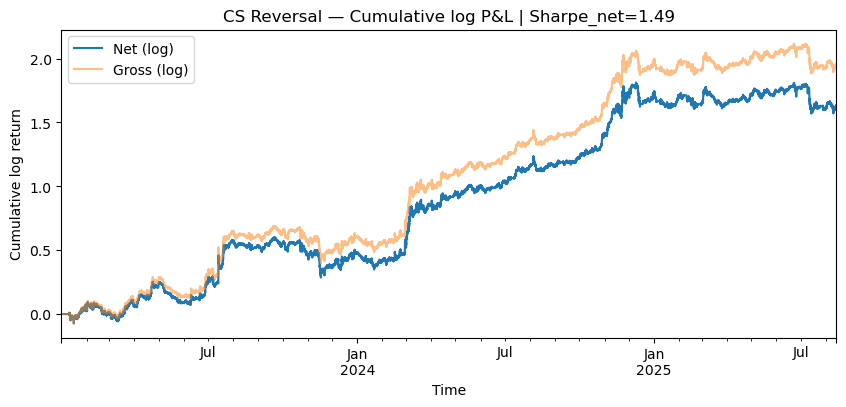

,best_combo
k,2.0000
band,1.5000
beta_win,168.0000
every,72.0000
vol_win,NaN
sharpe_gross,1.7854
sharpe_net,1.4894
ann_ret_gross,0.7476
ann_ret_net,0.6238
ann_vol_gross,0.4187


In [44]:
if best is None:
    print("No valid parameter set produced a finite Sharpe. Try widening the grid or slicing a different period.")
else:
    w_best, net_best, gross_best = best
    cum_net = net_best.fillna(0).cumsum()
    cum_gross = gross_best.fillna(0).cumsum()

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    cum_net.plot(ax=ax, label="Net (log)")
    cum_gross.plot(ax=ax, label="Gross (log)", alpha=0.5)
    ax.set_title(f"CS Reversal — Cumulative log P&L | Sharpe_net={best_meta['sharpe_net']:.2f}")
    ax.set_xlabel("Time"); ax.set_ylabel("Cumulative log return")
    ax.legend()
    plt.show()

    pd.options.display.float_format = "{:,.4f}".format
    display(pd.Series(best_meta).to_frame("best_combo"))

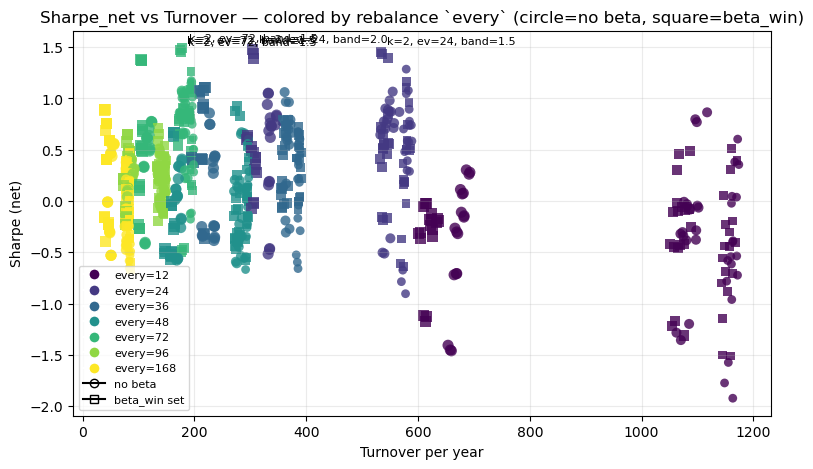

In [70]:
df = res.copy()

for c in ["sharpe_net","turnover_py","every","band","beta_win","k","vol_win"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

fig, ax = plt.subplots(figsize=(9,5))

every_vals = np.sort(df["every"].dropna().unique())
colors = {ev: plt.cm.viridis(i / max(1, len(every_vals)-1)) for i, ev in enumerate(every_vals)}

def marker_for_beta(x):
    return "o" if (pd.isna(x) or x==0) else "s"  # circle: no residualization, square: residualized

for _, row in df.iterrows():
    ax.scatter(
        row["turnover_py"], row["sharpe_net"],
        s=40 * (1.0 + 0.6*(row.get("band",1.0)-1.0)),   # a bit larger marker for bigger band
        c=[colors.get(row["every"], (0.5,0.5,0.5,0.6))],
        marker=marker_for_beta(row.get("beta_win", np.nan)),
        alpha=0.8, edgecolor="none"
    )

top = df.sort_values("sharpe_net", ascending=False).head(5)
for _, r in top.iterrows():
    ax.annotate(
        f"k={int(r['k'])}, ev={int(r['every'])}, band={r['band']}",
        xy=(r["turnover_py"], r["sharpe_net"]),
        xytext=(5,5), textcoords="offset points", fontsize=8
    )

ax.set_xlabel("Turnover per year")
ax.set_ylabel("Sharpe (net)")
ax.set_title("Sharpe_net vs Turnover — colored by rebalance `every` (circle=no beta, square=beta_win)")

from matplotlib.lines import Line2D
legend_elems = [Line2D([0],[0], marker='o', color='w', label=f"every={ev}",
                       markerfacecolor=colors[ev], markersize=8) for ev in every_vals]
legend_elems += [
    Line2D([0],[0], marker='o', color='k', label='no beta', markerfacecolor='none', markersize=6),
    Line2D([0],[0], marker='s', color='k', label='beta_win set', markerfacecolor='none', markersize=6)
]
ax.legend(handles=legend_elems, loc="best", fontsize=8)
ax.grid(True, alpha=0.25)
plt.show()

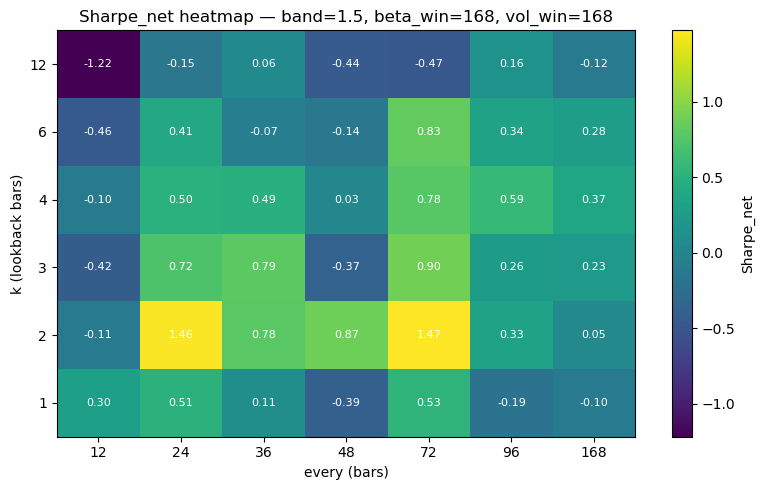

In [71]:
BAND     = 1.5
BETA_WIN = 168
VOL_WIN  = 168
COST_COL = "cost_bps"

slice_mask = (
    (res["band"] == BAND)
    & (res["beta_win"].fillna(-1) == (BETA_WIN if BETA_WIN is not None else -1))
    & (res["vol_win"].fillna(-1) == (VOL_WIN  if VOL_WIN  is not None else -1))
)

dfh = res.loc[slice_mask, ["k","every","sharpe_net"]].copy()
dfh["k"] = pd.to_numeric(dfh["k"], errors="coerce")
dfh["every"] = pd.to_numeric(dfh["every"], errors="coerce")

# pivot to (k x every) with max Sharpe per cell
heat = dfh.pivot_table(index="k", columns="every", values="sharpe_net", aggfunc="max")

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(heat.values, aspect="auto", origin="lower")
ax.set_xticks(range(len(heat.columns)))
ax.set_xticklabels(heat.columns.astype(int), rotation=0)
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index.astype(int))
ax.set_xlabel("every (bars)")
ax.set_ylabel("k (lookback bars)")
ax.set_title(f"Sharpe_net heatmap — band={BAND}, beta_win={BETA_WIN}, vol_win={VOL_WIN}")

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        txt = "" if np.isnan(val) else f"{val:.2f}"
        ax.text(j, i, txt, ha="center", va="center", fontsize=8, color="white" if not np.isnan(val) else "black")

fig.colorbar(im, ax=ax, label="Sharpe_net")
plt.tight_layout()
plt.show()

In [72]:
# Grid
grid = {
    "k":        [2, 3, 4, 5],
    "band":     [1.5, 2, 2.5],
    "beta_win": [None, 168],          # 1-week residualization vs BTC
    "every":    [24, 36, 48, 72],     # rebalance cadence in bars
    "vol_win":  [None, 24, 168],      # inverse-vol scaling window
}

R_all = ret.copy()

rows = []
best = None
best_meta = None
best_sharpe = -1e9

for k, band, beta_win, every, vol_win in product(
    grid["k"], grid["band"], grid["beta_win"], grid["every"], grid["vol_win"]
):
    w = cs_reversal_weights(
        R_all,
        k=k,
        band=band,
        beta_win=beta_win,
        bench=BENCH,
        vol_win=vol_win,
    )
    # Hold between rebalances
    w = downsample_weights(w, every=every)

    # Backtest
    net, gross, summ = backtest(w, R_all, cost_rate=COST_RATE)

    summ_dict = summ if isinstance(summ, dict) else (summ.to_dict() if hasattr(summ, "to_dict") else dict(summ))
    rec = {
        "k": k,
        "band": band,
        "beta_win": beta_win,
        "every": every,
        "vol_win": vol_win,
        **summ_dict,
    }
    rows.append(rec)

    # Track best by net Sharpe
    s_net = rec.get("sharpe_net")
    if pd.notna(s_net) and s_net > best_sharpe:
        best_sharpe = s_net
        best = (w, net, gross)
        best_meta = rec

res = pd.DataFrame(rows).sort_values("sharpe_net", ascending=False).reset_index(drop=True)
print("Top 10 parameter sets by net Sharpe:")
display(res.head(10))

if best_meta is not None:
    print("\nBest params:", {k: best_meta[k] for k in ["k","band","beta_win","every","vol_win"]},
          f"| Sharpe_net={best_meta['sharpe_net']:.2f}")
else:
    print("\nBest params: None (all Sharpe_net were NaN)")

Top 10 parameter sets by net Sharpe:


,k,band,beta_win,every,vol_win,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,4,2.5000,168.0000,24,24.0000,2.0668,1.7670,0.4285,0.3662,0.2073,0.2072,0.0102,88.9974,0.0623
1,4,2.5000,168.0000,24,NaN,2.0668,1.7670,0.4285,0.3662,0.2073,0.2072,0.0102,88.9974,0.0623
2,2,2.5000,168.0000,24,NaN,2.0289,1.7284,0.4217,0.3592,0.2078,0.2078,0.0102,89.3028,0.0625
3,2,2.5000,168.0000,24,24.0000,2.0289,1.7284,0.4217,0.3592,0.2078,0.2078,0.0102,89.3028,0.0625
4,4,2.5000,168.0000,24,168.0000,2.0024,1.7045,0.4142,0.3524,0.2068,0.2068,0.0101,88.2338,0.0618
5,2,2.5000,168.0000,24,168.0000,1.9647,1.6660,0.4074,0.3455,0.2074,0.2074,0.0101,88.5392,0.0620
6,2,1.5000,168.0000,72,NaN,1.7854,1.4894,0.7476,0.6238,0.4187,0.4188,0.0202,176.8736,0.1238
7,2,2.0000,168.0000,24,168.0000,2.0552,1.4760,0.7525,0.5402,0.3661,0.3660,0.0346,303.1779,0.2122
8,2,1.5000,168.0000,72,168.0000,1.7745,1.4725,0.7143,0.5929,0.4025,0.4026,0.0198,173.3705,0.1214
9,2,1.5000,168.0000,24,168.0000,2.3059,1.4567,1.0127,0.6397,0.4392,0.4392,0.0608,532.8302,0.3730



Best params: {'k': 4, 'band': 2.5, 'beta_win': 168, 'every': 24, 'vol_win': 24} | Sharpe_net=1.77


## Extended Results Summary

After expanding the parameter grid, the **best configuration** achieved a  
**net Sharpe ≈ 1.77** with:

- `k = 4` (4-bar lookback)
- `band = 2.5`
- `beta_win = 168` (≈ 1 week residualization vs BTC)
- `every = 24` (rebalance once per day)
- `vol_win = 24` (inverse-vol scaling over 1 day)

### Observations
- Multiple parameter sets clustered near this optimum (Sharpe 1.66–1.73),  
  indicating stability around **short-to-medium lookbacks (k=2–4)**,  
  **band = 2.5**, and **daily rebalancing**.
- Annualized returns in the top configs were ~0.35–0.37,  
  with volatilities ~0.21, yielding strong risk-adjusted performance.
- Turnover was relatively low (~89 per year), so trading costs had  
  a modest impact (`cost_py ≈ 0.06`).
- Longer rebalancing intervals (72 bars, ~3 days) produced positive Sharpe,  
  but with higher turnover and greater cost drag.

📌 **Conclusion:** The reversal strategy appears most effective when  
residualized vs BTC, using **short k (2–4)**, **strong banding (2.0–2.5)**,  
and **daily rebalancing** with moderate volatility scaling.
